In [1]:
%load_ext autoreload
%autoreload 2
from utils import plot_utils
from utils import custom_functions as cuf

import os
import sys
#sys.path.append("../") # go to parent 
from OpenEphys_Analysis.utils.custom_functions import update_progress
import glob
import ntpath
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import math
import seaborn as sns
import pandas as pd
import warnings
from itertools import chain
import random


warnings.filterwarnings('ignore')

In [2]:
# Task
BpodProtocol = '/Two_Alternative_Choice/'
# Behavioural data
GeneralDirectory = cuf.get_data_folder() + '/Behavioural_Data/Bpod_data/'

output_directory_name =  'D1andD2opto'

outputDir = GeneralDirectory + output_directory_name + '_Analysis/'
if not os.path.isdir(outputDir):
    print('I dont find this')
else:
    # Read the dataframe
    AnimalsDF = pd.read_pickle(outputDir + output_directory_name + '_dataframe.pkl')
    print('Dataframe read')

Dataframe read


In [3]:
# get a list of each animalID in each condition
for EG in pd.unique(AnimalsDF.ExperimentalGroup):
    print(str(EG) + ':')
    for AI in pd.unique(AnimalsDF[AnimalsDF.ExperimentalGroup == EG].AnimalID):
        print('  ' + AI)

optoinhibition:
  D1opto-01
  D1opto-02
  D1opto-03
  D1opto-04
  D1opto-05
  D1opto-06
  D1opto-07
  D1opto-08
  D1opto-09
  D2opto-01
  D2opto-02
  D2opto-03
  D2opto-04
  D2opto-05
  D2opto-06
  D2opto-07


In [17]:
# send data to Joaquin
# d1_animals_to_select = ['D1opto-03', 'D1opto-04', 'D1opto-05']
# d2_animals_to_select = ['D2opto-03', 'D2opto-04', 'D2opto-05']
opto_to_select = ['Right', 'Left']
columns_to_select = ['AnimalID', 'SessionID', 'TrialHighPerc', 'FirstPoke', 'OptoStim', 'Stimulation']

optodf = AnimalsDF[AnimalsDF.SessionID.isin(sess_list)].copy()
optodf = optodf[optodf.Stimulation.isin(opto_to_select)]
optodf = optodf[columns_to_select]
optodf['Cohort'] = np.nan
for animal in pd.unique(optodf.AnimalID):
    optodf.at[optodf.AnimalID == animal, 'Cohort'] = animal.split('-')[0]

optodf.rename(columns={"FirstPoke": "Side_selected", "TrialHighPerc": "Percentage_of_high_frequency",
                      "OptoStim": "Optostimulation", 'Stimulation': 'Optostimulation_side'})
optodf

,AnimalID,SessionID,TrialHighPerc,FirstPoke,OptoStim,Stimulation,Cohort
5690,D1opto-01,D1opto-01 Jul27 10:34,18.0,2.0,0.0,Left,D1opto
5693,D1opto-01,D1opto-01 Jul27 10:34,98.0,1.0,0.0,Left,D1opto
5694,D1opto-01,D1opto-01 Jul27 10:34,18.0,1.0,1.0,Left,D1opto
5695,D1opto-01,D1opto-01 Jul27 10:34,82.0,2.0,0.0,Left,D1opto
5696,D1opto-01,D1opto-01 Jul27 10:34,82.0,2.0,0.0,Left,D1opto
...,...,...,...,...,...,...,...
162600,D2opto-07,D2opto-07 Oct27 11:44,98.0,1.0,1.0,Left,D2opto
162601,D2opto-07,D2opto-07 Oct27 11:44,34.0,1.0,0.0,Left,D2opto
162602,D2opto-07,D2opto-07 Oct27 11:44,18.0,2.0,0.0,Left,D2opto
162603,D2opto-07,D2opto-07 Oct27 11:44,50.0,2.0,1.0,Left,D2opto


In [20]:
optodf.to_pickle(outputDir + 'for_Joaquin_glm_opto_unilateral_sessions_selected_dataframe.pkl')

#### Create a summary of the stimulation sessions for every mouse

In [4]:
#Subselect dataset
pulledData = AnimalsDF[AnimalsDF.Stimulation != "NoStimulation"]
pulledData = pulledData[pulledData.Protocol == 'Aud_Psycho']
# pulledData = pulledData[pulledData.AnimalID.isin(['D1opto-03', 'D2opto-04'])]

### Custom fitting

##### Test a different way of calculating / visualizing differences. Generate 'fake opto datasets' and plot the distributions for every difficulty

In [5]:
# Generate random optostimulation choices for every session
n_times = 1000
data = np.empty([len(pd.unique(pulledData['SessionID'])), 3], dtype=object)

for i, session in enumerate(pd.unique(pulledData['SessionID'])):
    # generate the random dataset, and save it to a general dataframe for later use
    session_df = pulledData[pulledData['SessionID'] == session]
    roc = cuf.get_random_optolike_choices(df=session_df, n_times=n_times)
    _, odf = cuf.splitOpto(session_df)
    roc_ds = np.apply_along_axis(cuf.get_choices, 1, roc, trialsDif=odf['Difficulty'])
    avail_diffs = roc_ds[0,0,:]
    rand_choices_ds = roc_ds[:,1,:]
    # fill
    data[i] = [session, avail_diffs, rand_choices_ds]
    
    update_progress(i / len(pd.unique(pulledData['SessionID'])))

random_opto_df = pd.DataFrame(data, columns=['SessionID', 'Difficulties', 'Random_choices'])
update_progress(1)

Progress: [####################] 100.0%


##### populate the random dataframe with parameters about the sigmoid fits for every random occurrence

In [17]:
random_opto_df['sf_slopes'] = None
random_opto_df['sf_intercepts'] = None
random_opto_df['sf_upper-bounds'] = None
random_opto_df['sf_lower-bounds'] = None

for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    avail_diffs = random_opto_df.loc[session_idx].Difficulties
    rand_choices_ds = random_opto_df.loc[session_idx].Random_choices
    
    slope_list = np.empty(len(rand_choices_ds))
    inter_list = np.empty(len(rand_choices_ds))
    upper_list = np.empty(len(rand_choices_ds))
    lower_list = np.empty(len(rand_choices_ds))
    updown_list = np.empty(len(rand_choices_ds))

    for i in range(len(slope_list)):
        s, b, u, l = cuf.fit_custom_sigmoid(difficulty=avail_diffs, performance=rand_choices_ds[i])
        slope_list[i] = s
        inter_list[i] = b
        upper_list[i] = u
        lower_list[i] = l

    random_opto_df.at[session_idx, 'sf_slopes'] = slope_list
    random_opto_df.at[session_idx, 'sf_intercepts'] = inter_list
    random_opto_df.at[session_idx, 'sf_upper-bounds'] = upper_list
    random_opto_df.at[session_idx, 'sf_lower-bounds'] = lower_list

    update_progress((sc + 1) / len(pd.unique(random_opto_df['SessionID'])))

Progress: [####################] 100.0%


In [107]:
# intercept is the left-right shift of the curve
# I need another metric for the up-down shift
# Is the predicted value at the 50% the proper measure of this?

# Calculate the area between the curves of the random fits and the opto ones,
# as an alternative measure to the 50% value of the curve to measure the shift

random_opto_df['sf_updown_shift'] = None
x = np.linspace(0, 100)

for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get data for opto
    opto_df = pulledData[(pulledData['SessionID'] == session) & (pulledData['OptoStim']==1)]
    trialsDif = np.array(opto_df['TrialHighPerc'])
    sideSelected = np.array(opto_df['FirstPoke'])
    difficulty, performance = cuf.get_choices(sideSelected, trialsDif)
    so, bo, uo, lo = cuf.fit_custom_sigmoid(difficulty=difficulty, performance=performance) 
    opto_yvals = cuf.sigmoid_func(x, *[so, bo, uo, lo])
    
    # get data for the shuffles
    slope_list = random_opto_df.loc[session_idx].sf_slopes
    inter_list = random_opto_df.loc[session_idx].sf_intercepts
    upper_list = random_opto_df.loc[session_idx, 'sf_upper-bounds']
    lower_list = random_opto_df.loc[session_idx, 'sf_lower-bounds']
    updown_list = np.empty(len(slope_list))

    for i in range(len(slope_list)):
        s, b, u, l = slope_list[i], inter_list[i], upper_list[i], lower_list[i]
        y_vals = cuf.sigmoid_func(x, *[s, b, u, l])
        # calculate area and normalize
        updown_list[i] = np.sum(y_vals - opto_yvals) / len(x)
    
    random_opto_df.at[session_idx, 'sf_updown_shift'] = updown_list
    update_progress((sc + 1) / len(pd.unique(random_opto_df['SessionID'])))

Progress: [####################] 100.0%


In [109]:
# calculate, for each session, the std of the distributions of these shifts,
# the lower and upper percentiles
# the values of the real opto data,
# as well as the mean, and it's difference with the opto trials
random_opto_df['slopes_mean'] = None
random_opto_df['slopes_std'] = None
random_opto_df['slopes_low_per'] = None
random_opto_df['slopes_high_per'] = None

random_opto_df['shift_mean'] = None
random_opto_df['shift_std'] = None
random_opto_df['shift_low_per'] = None
random_opto_df['shift_high_per'] = None

random_opto_df['opto_slope'] = None
random_opto_df['opto_shift'] = None

# Get a column with the mouse name
random_opto_df['AnimalID'] = None
# And the stimulation side
random_opto_df['Stimulation'] = None
# And the type of mouse
random_opto_df['Genotype'] = None

for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    slopes = random_opto_df.loc[session_idx].sf_slopes
    shifts = random_opto_df.loc[session_idx].sf_updown_shift
    
    opto_df = pulledData[(pulledData['SessionID'] == session) & (pulledData['OptoStim']==1)]
    trialsDif = np.array(opto_df['TrialHighPerc'])
    sideSelected = np.array(opto_df['FirstPoke'])
    difficulty, performance = cuf.get_choices(sideSelected, trialsDif)
    s, b, u, l = cuf.fit_custom_sigmoid(difficulty=difficulty, performance=performance)
#     ups = cuf.sigmoid_func(50, s, b, u, l)
    ups = 0
    
    random_opto_df.at[session_idx, 'slopes_mean'] = np.mean(slopes)
    random_opto_df.at[session_idx, 'slopes_std'] = np.std(slopes)
    random_opto_df.at[session_idx, 'slopes_low_per'] = np.percentile(slopes, 5)
    random_opto_df.at[session_idx, 'slopes_high_per'] = np.percentile(slopes, 95)
    
    random_opto_df.at[session_idx, 'shift_mean'] = np.mean(shifts)
    random_opto_df.at[session_idx, 'shift_std'] = np.std(shifts)
    random_opto_df.at[session_idx, 'shift_low_per'] = np.percentile(shifts, 5)
    random_opto_df.at[session_idx, 'shift_high_per'] = np.percentile(shifts, 95)
    
    random_opto_df.at[session_idx, 'opto_slope'] = s
    random_opto_df.at[session_idx, 'opto_shift'] = ups
    
    mouse_name = random_opto_df.loc[session_idx].SessionID.split(' ')[0]
    random_opto_df.at[session_idx, 'AnimalID'] = mouse_name
    random_opto_df.at[session_idx,'Genotype'] = mouse_name.split('-')[0]
    random_opto_df.at[session_idx, 'Stimulation'] = opto_df.iloc[0]['Stimulation']

    update_progress((sc + 1) / len(pd.unique(pulledData['SessionID'])))

Progress: [####################] 100.0%


In [113]:
# save this dataframe as it takes very long to calculate
random_opto_df.to_pickle(outputDir + output_directory_name + '_random-opto_dataframe.pkl')

In [5]:
# read it
random_opto_df = pd.read_pickle(outputDir + output_directory_name + '_random-opto_dataframe.pkl')

Progress: [####################] 100.0%


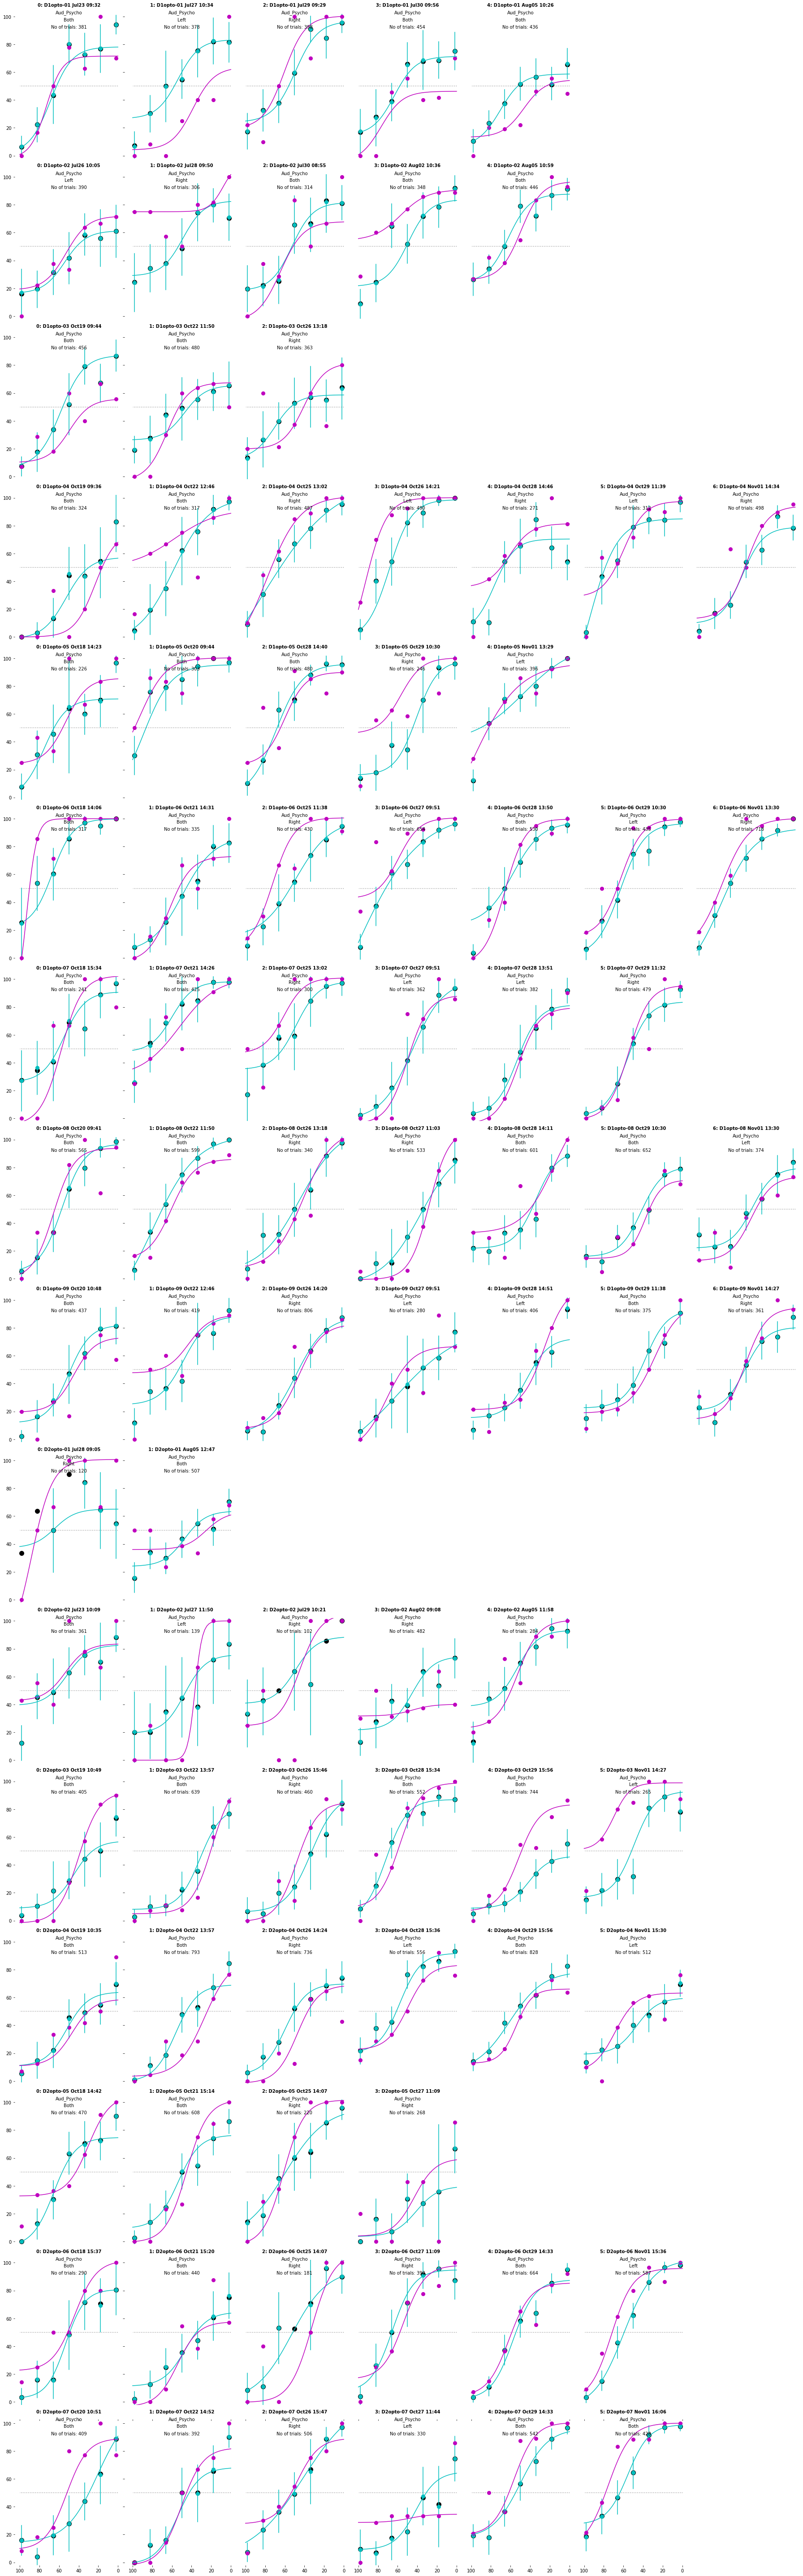

In [13]:
# Plot the data with the error bars for the random sampling, and the custom fitting

CondList = [(pulledData['OptoStim']==0),
            (pulledData['OptoStim']==1)]
ColorList = ['c', 'm']
LabelList = ['Normal', 'Opto']

n_cols = pulledData.groupby('AnimalID')['SessionID'].nunique().max()

fig, axs = plt.subplots(len(pd.unique(pulledData['AnimalID'])), n_cols,
                        figsize=(25, 5 * len(pd.unique(pulledData['AnimalID']))),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=1)

for ax in axs.ravel(): ax.axis('off')

for an_counter, animal in enumerate(pd.unique(pulledData['AnimalID'])):
    animal_df = pulledData[pulledData['AnimalID'] == animal]
    
    for counter, session in enumerate(pd.unique(animal_df['SessionID'])):
        session_df = pulledData[pulledData['SessionID'] == session]
        
        ax = axs[an_counter, counter]        
        ax.hlines(50, 0, 100, linestyles='dotted', alpha=0.4)

        avail_diffs = random_opto_df[random_opto_df.SessionID == session].Difficulties.item()
        rand_choices_ds = random_opto_df[random_opto_df.SessionID == session].Random_choices.item()
        
        plot_utils.plot_random_optolike_choices(df=session_df,
                                                ax=ax,
                                                fake_dataset_m_and_std=[avail_diffs,
                                                                        np.mean(rand_choices_ds, axis=0),
                                                                        np.std(rand_choices_ds, axis=0)])
        # overlay fits
        for i, condition in enumerate(CondList):
            plot_utils.plot_regression(df=animal_df[(animal_df['SessionID'] == session) & condition], ax=ax,
                                       color=ColorList[i], label=LabelList[i], plot_points=False)
        #axs[counter].set_ylabel('')
        #axs[counter].set_xlabel('')
        ax.axis('on')
        # remove some ticks
        ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                       labelleft='on', labelbottom='on')
        if not ax.is_first_col():
            ax.set_ylabel('')
            ax.set_yticks([])
        if not ax.is_last_row():
            ax.set_xlabel('')
            ax.set_xticks([])
                   
        ax.set_ylim(-2., 102.)
        #ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
        ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
                       labelleft='on', labelbottom='on')
        # get rid of the frame
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        plt.tight_layout()
        
        ax.invert_xaxis()
        
#         ax.get_legend().remove()
        ax.text(.5,1.05, str(counter) + ': ' + (session), \
                          horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

        ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.95, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.9, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
                          horizontalalignment='center', transform=ax.transAxes)

    update_progress(an_counter / len(pd.unique(pulledData['AnimalID'])))
    
update_progress(1)
plt.savefig(outputDir + output_directory_name + '_difficulty_significance_for_individual_opto_sessions.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [19]:
def plot_hist_and_line(data_for_hist, line, ax):
    ax.hist(data_for_hist, bins=100, color='c')
    ax.axvline(x=line, color='m')
    return ax

Progress: [####################] 100.0%


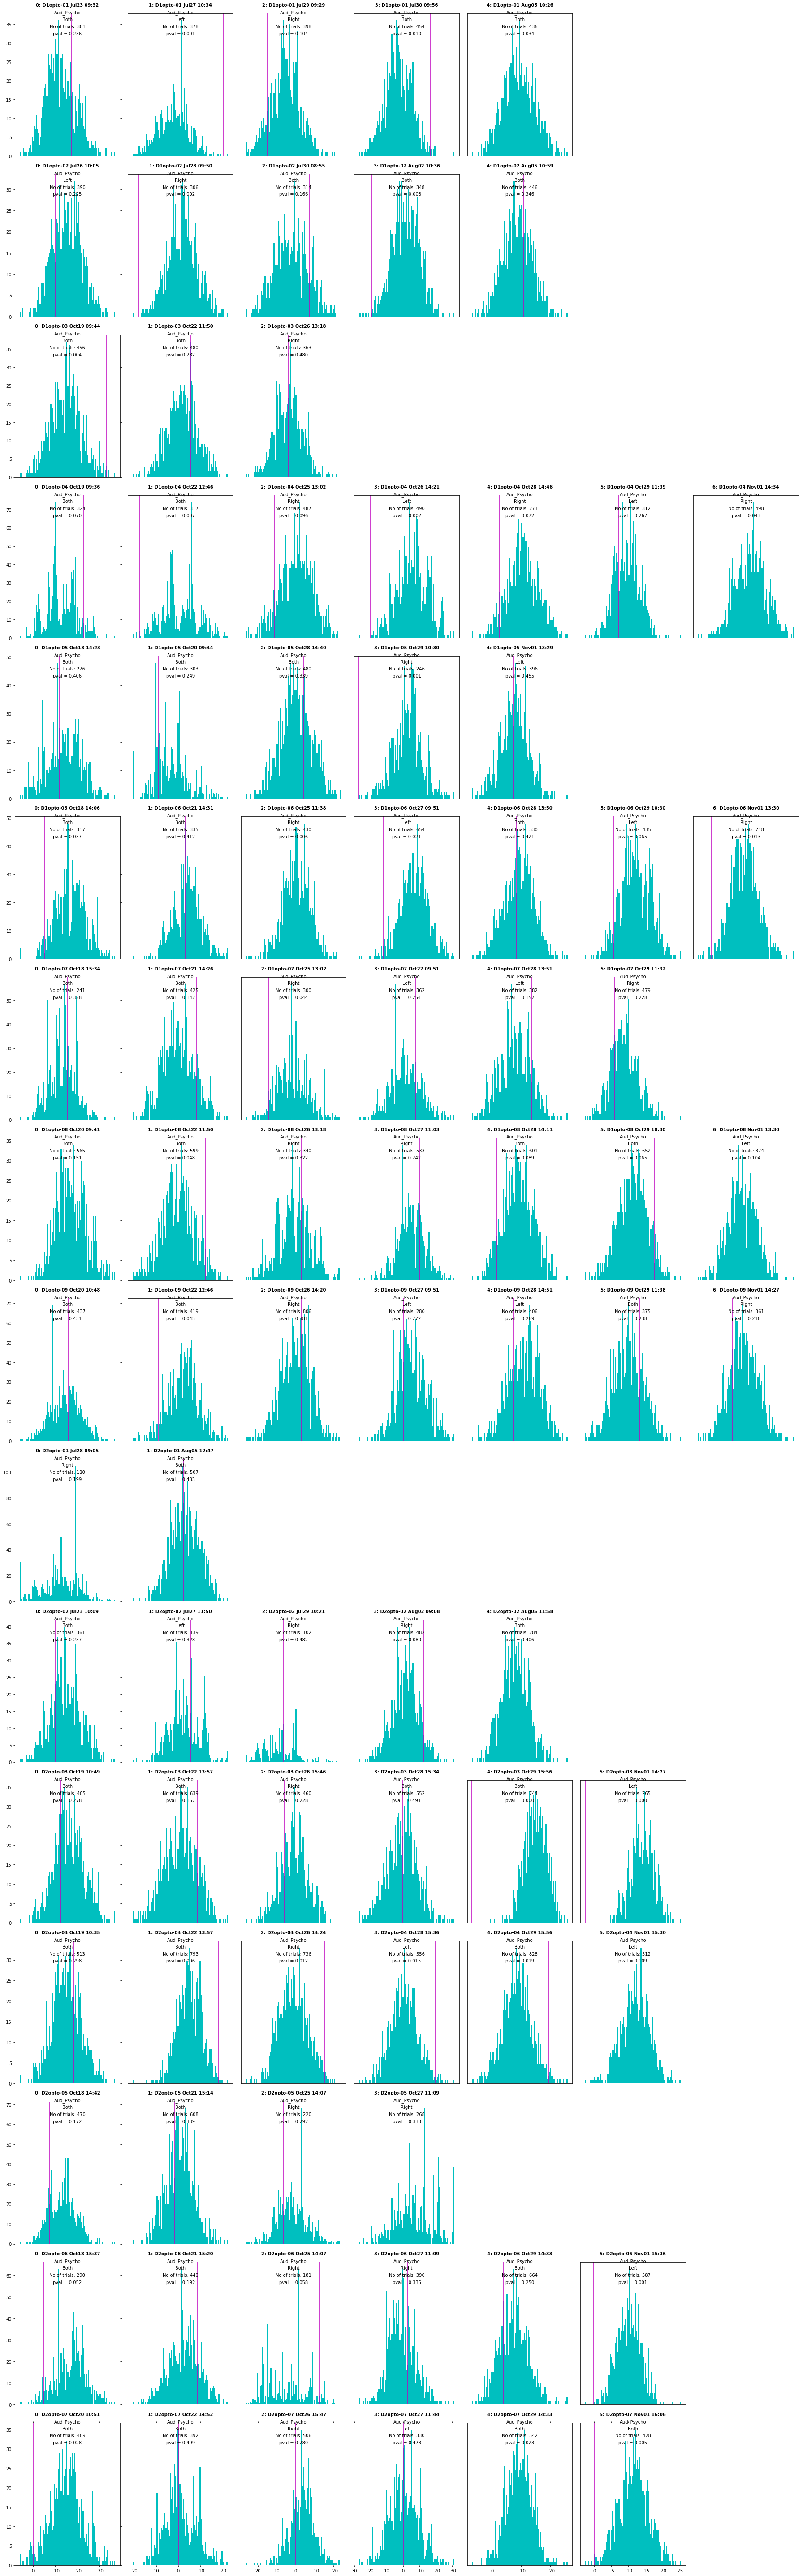

In [114]:
# Plot the distributions

n_cols = pulledData.groupby('AnimalID')['SessionID'].nunique().max()

fig, axs = plt.subplots(len(pd.unique(pulledData['AnimalID'])), n_cols,
                        figsize=(25, 5 * len(pd.unique(pulledData['AnimalID']))),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=1)

for ax in axs.ravel(): ax.axis('off')

for an_counter, animal in enumerate(pd.unique(pulledData['AnimalID'])):
    animal_df = pulledData[pulledData['AnimalID'] == animal]
    
    for counter, session in enumerate(pd.unique(animal_df['SessionID'])):
        session_df = pulledData[pulledData['SessionID'] == session]
        
        ax = axs[an_counter, counter]        

        session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
#         opto_df = pulledData[(pulledData['SessionID'] == session) & (pulledData['OptoStim']==1)]
#         trialsDif = np.array(opto_df['TrialHighPerc'])
#         sideSelected = np.array(opto_df['FirstPoke'])
#         difficulty, performance = cuf.get_choices(sideSelected, trialsDif)

#         s, b, u, l = cuf.fit_custom_sigmoid(difficulty=difficulty, performance=performance)
#         ups = cuf.sigmoid_func(50, s, b, u, l)
        ups = 0
        plot_hist_and_line(random_opto_df.loc[session_idx].sf_updown_shift, ups, ax=ax)
        
        #axs[counter].set_ylabel('')
        #axs[counter].set_xlabel('')
        ax.axis('on')
        # remove some ticks
        ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                       labelleft='on', labelbottom='on')
        if not ax.is_first_col():
            ax.set_ylabel('')
            ax.set_yticks([])
        if not ax.is_last_row():
            ax.set_xlabel('')
            ax.set_xticks([])
                   
#         ax.set_ylim(-2., 102.)
        #ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
        ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
                       labelleft='on', labelbottom='on')
        
        
        # calculate pval
        pval = np.sum(random_opto_df.loc[session_idx].sf_updown_shift > ups) / len(random_opto_df.loc[session_idx].sf_updown_shift)
        if pval > .5: pval = 1 - pval
        
        
        # get rid of the frame if not significant
        if pval > .05:
            for spine in ax.spines.values():
                spine.set_visible(False)
        
        plt.tight_layout()
        
        ax.invert_xaxis()
        
#         ax.get_legend().remove()
        ax.text(.5,1.05, str(counter) + ': ' + (session), \
                          horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

        ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.95, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.9, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.85, 'pval = ' + "{:.3f}".format(pval), horizontalalignment='center', transform=ax.transAxes)


    update_progress(an_counter / len(pd.unique(pulledData['AnimalID'])))
    
update_progress(1)
plt.savefig(outputDir + output_directory_name + '_significance_shifts.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

#### Group sessions together

Progress: [####################] 100.0%


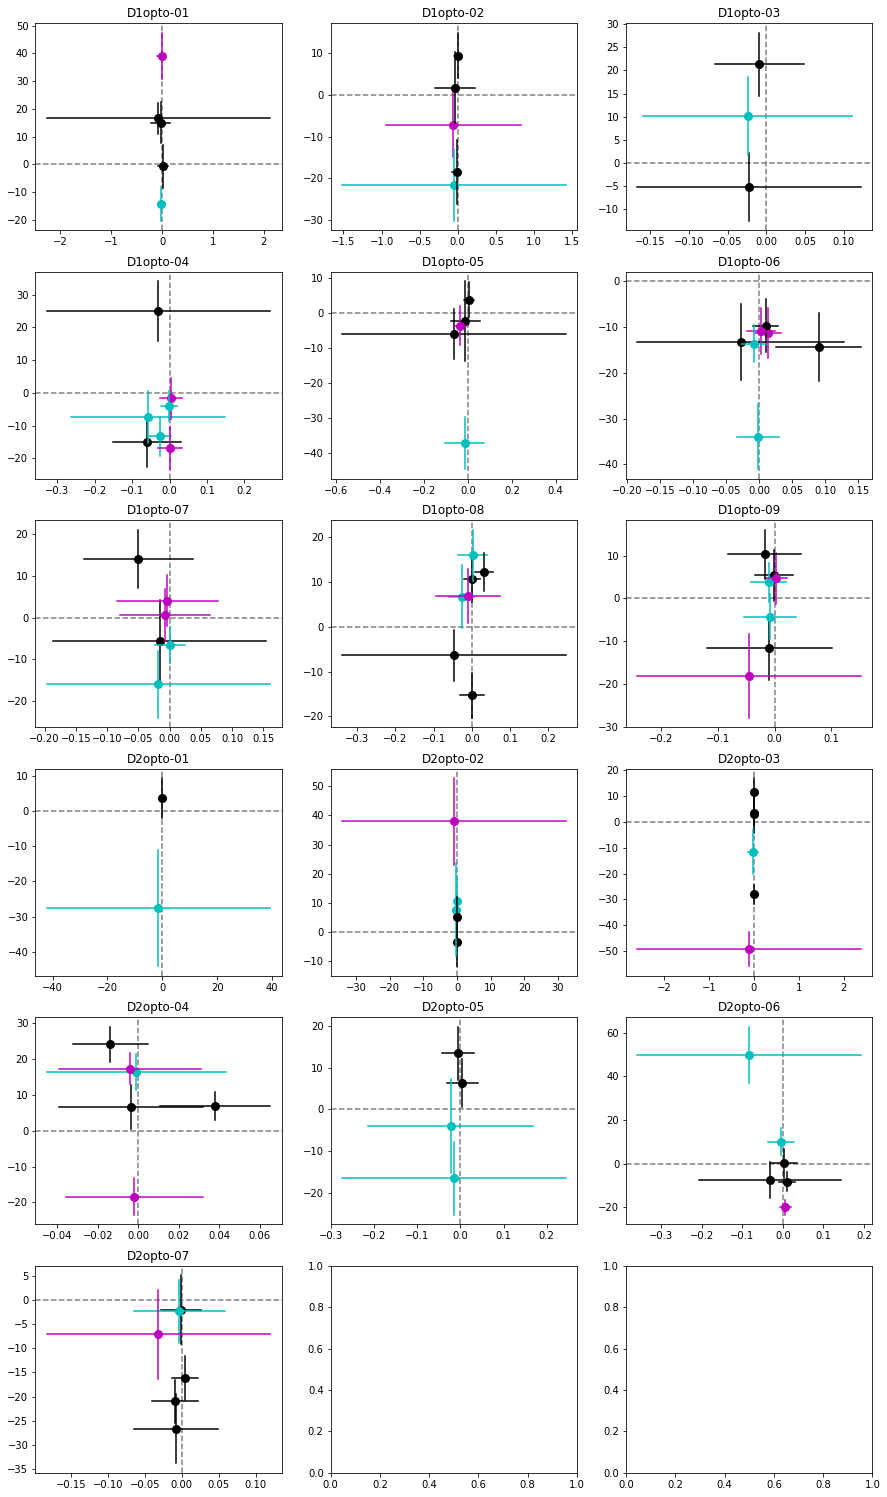

In [111]:
# make a plot for every mouse in with the slopes and shifts are plotted for every session
stim_types = ['Both', 'Right', 'Left']
colors = ['k', 'c', 'm']


fig, axs = plt.subplots(math.ceil(len(pd.unique(random_opto_df.AnimalID))/3), 3,
                        figsize=(15, 5 * len(pd.unique(random_opto_df.AnimalID))/3),
                        facecolor='w', edgecolor='k', sharex=False, sharey=False)
axs = axs.ravel()

for ac, animal in enumerate(pd.unique(random_opto_df.AnimalID)):
    ax = axs[ac]
    ax.axvline(0, color='grey', linestyle='--')
    ax.axhline(0, color='grey', linestyle='--')
    ax.set_title(animal)
    
    animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]

    for session in pd.unique(animal_rdf.SessionID):
        session_idx = animal_rdf.index[animal_rdf.SessionID == session].item()
        sl_d = animal_rdf.loc[session_idx].slopes_mean_dif
        sh_d = animal_rdf.loc[session_idx].shift_mean_dif
        sl_std = animal_rdf.loc[session_idx].slopes_std
        sh_std = animal_rdf.loc[session_idx].shift_std
        st_t = animal_rdf.loc[session_idx].Stimulation
        st_idx = stim_types.index(st_t)
        
        ax.plot(sl_d, sh_d, 'o', ms=8,color=colors[st_idx])
        ax.plot([sl_d, sl_d], [sh_d-sh_std, sh_d+sh_std], color=colors[st_idx])
        ax.plot([sl_d-sl_std, sl_d+sl_std], [sh_d, sh_d], color=colors[st_idx])

    update_progress((ac + 1) / len(pd.unique(random_opto_df.AnimalID)))

plt.savefig(outputDir + output_directory_name + '_significance_slope-and-shift_grouped-per-animal.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

Progress: [####################] 100.0%


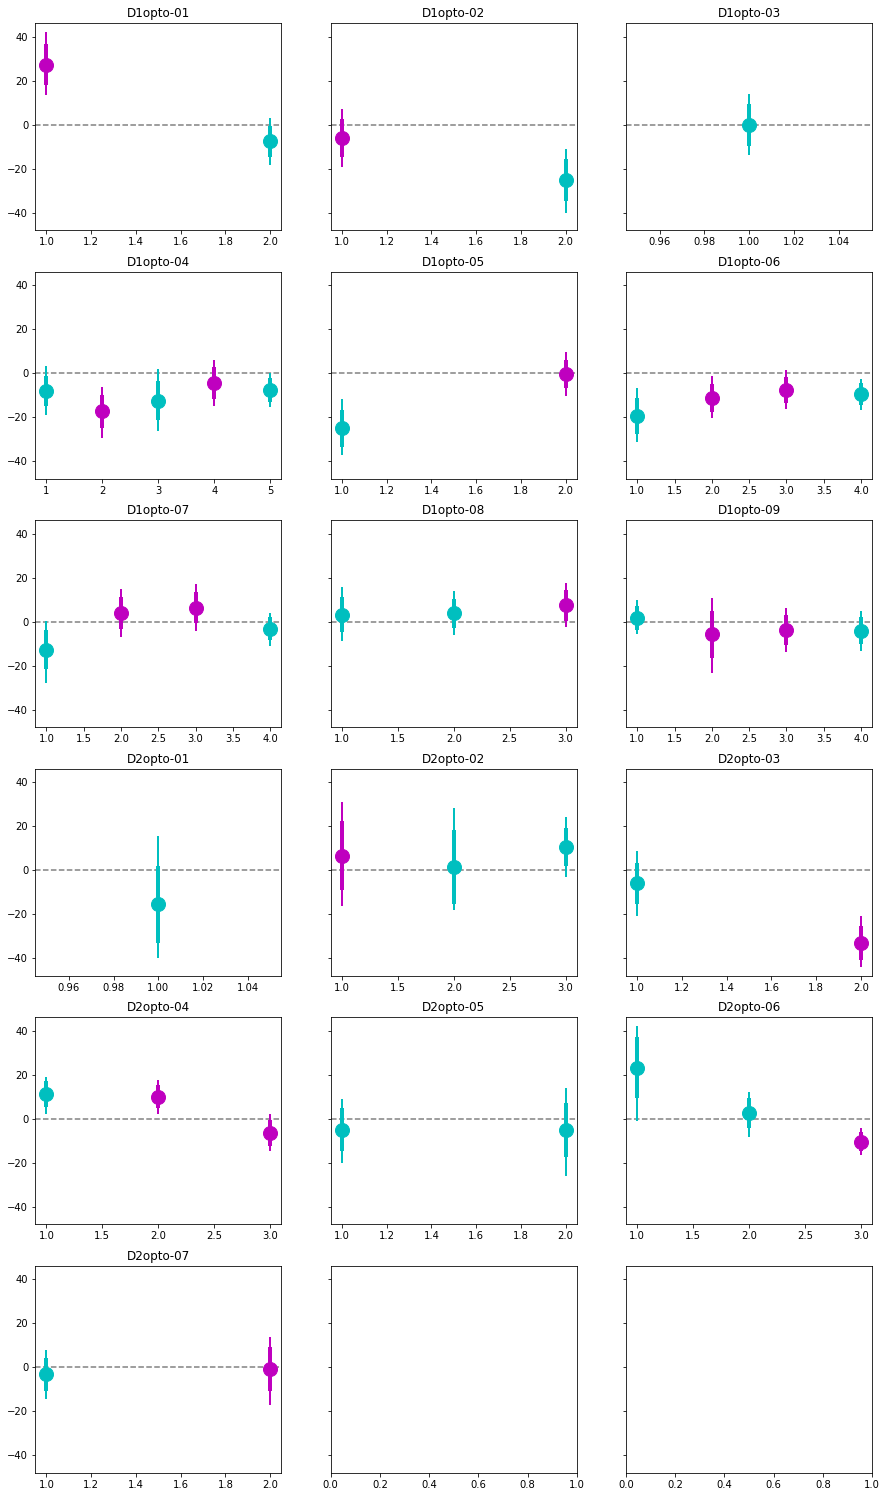

In [116]:
# plot only the shift for unilateral stimulations, adding the percentiles

stim_types = ['Right', 'Left']
colors = ['c', 'm']

fig, axs = plt.subplots(math.ceil(len(pd.unique(random_opto_df.AnimalID))/3), 3,
                        figsize=(15, 5 * len(pd.unique(random_opto_df.AnimalID))/3),
                        facecolor='w', edgecolor='k', sharex=False, sharey=True)
axs = axs.ravel()

for ac, animal in enumerate(pd.unique(random_opto_df.AnimalID)):
    ax = axs[ac]
#     ax.axvline(0, color='grey', linestyle='--')
    ax.axhline(0, color='grey', linestyle='--')
    ax.set_title(animal)
    
    animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]
    sc = 0
    for session in pd.unique(animal_rdf.SessionID):
        session_idx = animal_rdf.index[animal_rdf.SessionID == session].item()
        st_t = animal_rdf.loc[session_idx].Stimulation
        if st_t in stim_types:
            sc = sc + 1
            o_s = animal_rdf.loc[session_idx].opto_shift
            sh_d = animal_rdf.loc[session_idx].shift_mean - o_s
            sh_std = animal_rdf.loc[session_idx].shift_std
            sh_lper = animal_rdf.loc[session_idx].shift_low_per - o_s
            sh_hper = animal_rdf.loc[session_idx].shift_high_per - o_s
            st_idx = stim_types.index(st_t)

            ax.plot(sc, sh_d, 'o', ms=14,color=colors[st_idx])
            ax.plot([sc, sc], [sh_d-sh_std, sh_d+sh_std], color=colors[st_idx], linewidth=4)
            ax.plot([sc, sc], [sh_lper, sh_hper], color=colors[st_idx], linewidth=2)

    update_progress((ac + 1) / len(pd.unique(random_opto_df.AnimalID)))

plt.savefig(outputDir + output_directory_name + '_significance_shift_grouped-per-animal.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

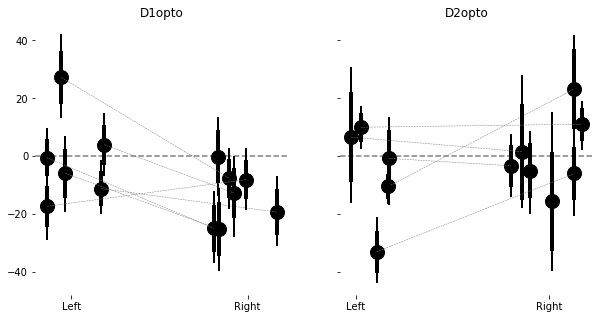

In [209]:
# Remove the JAWS mice
mice_to_remove = ['D1opto-08', 'D1opto-09']
animals_list = set(pd.unique(random_opto_df.AnimalID)) - set(mice_to_remove)
# Take the first two distinct tests in each direction for the grouping, and plot first left and then right
# add jitter and connect the sessions for the same mouse
jitter = 0.2
alpha = 1

stim_types = ['Left', 'Right']
mice_cohorts = ['D1opto', 'D2opto'] 
colors = ['k', 'k']

fig, axs = plt.subplots(1, len(mice_cohorts), figsize = (5 * len(mice_cohorts), 5), sharey=True)

axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.axhline(0, color='grey', linestyle='--')
    ax.set_title(mice_cohorts[i])
#     ax.tick_params(which='both', top='off', bottom='off', left='on', right='off',
#                        labelleft='on', labelbottom='on')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(stim_types)
    # get rid of the frame
    for spine in ax.spines.values():
        spine.set_visible(False)


for animal in animals_list:
    animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]
    # flags for plotting only the first session (they are ordered)
    stim_flags = np.zeros(len(stim_types))
    # create an array to store connecting dots
    animal_ys = np.zeros(len(stim_types))
    animal_xs = np.zeros(len(stim_types))
    animal_flag = np.zeros(len(stim_types))
    for session in pd.unique(animal_rdf.SessionID):
        session_idx = animal_rdf.index[animal_rdf.SessionID == session].item()
        cohort = animal_rdf.loc[session_idx].Genotype
        st_t = animal_rdf.loc[session_idx].Stimulation
        ax = axs[mice_cohorts.index(cohort)]
        if st_t in stim_types:
            st_t_idx = stim_types.index(st_t)
            if stim_flags[st_t_idx] == 0:
                stim_flags[st_t_idx] = 1
                o_s = animal_rdf.loc[session_idx].opto_shift
                sh_d = animal_rdf.loc[session_idx].shift_mean - o_s
                sh_std = animal_rdf.loc[session_idx].shift_std
                sh_lper = animal_rdf.loc[session_idx].shift_low_per - o_s
                sh_hper = animal_rdf.loc[session_idx].shift_high_per - o_s
                
                imp_jit = random.uniform(-jitter, jitter)
                x_pos = st_t_idx + imp_jit
                animal_xs[st_t_idx] = x_pos
                animal_ys[st_t_idx] = sh_d
                animal_flag[st_t_idx] = 1

                #means
                ax.plot(x_pos, sh_d, 'o', ms=14,color=colors[st_t_idx], alpha=alpha)
                #stds
                ax.plot([x_pos, x_pos], [sh_d-sh_std, sh_d+sh_std], color=colors[st_t_idx], linewidth=4, alpha=alpha)
                #percentiles
                ax.plot([x_pos, x_pos], [sh_lper, sh_hper], color=colors[st_t_idx], linewidth=2, alpha=alpha)
            
    #connect
    if np.all(animal_flag == 1):
        ax.plot(animal_xs, animal_ys, color = 'grey', linewidth = 0.5, linestyle = '--')

    #update_progress((ac + 1) / len(pd.unique(random_opto_df.AnimalID)))

plt.savefig(outputDir + output_directory_name + '_shift_grouped-with-bars.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

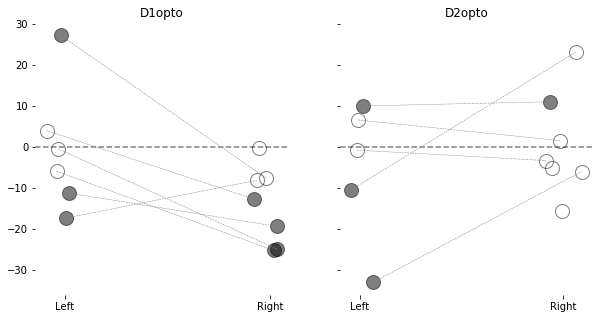

In [12]:
# remove the error bars as it is too much. Maybe?
# Try colouring the dots if they are significant
# Remove the JAWS mice and flat fibers
mice_to_remove = ['D1opto-08', 'D1opto-09']
#                   'D1opto-06', 'D1opto-07', 'D2opto-03', 'D2opto-04']
animals_list = set(pd.unique(random_opto_df.AnimalID)) - set(mice_to_remove)
# Take the first two distinct tests in each direction for the grouping, and plot first left and then right
# add jitter and connect the sessions for the same mouse
jitter = 0.1
alpha = 0.5

stim_types = ['Left', 'Right']
mice_cohorts = ['D1opto', 'D2opto'] 
colors = ['k', 'k']

fig, axs = plt.subplots(1, len(mice_cohorts), figsize = (5 * len(mice_cohorts), 5), sharey=True)

axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.axhline(0, color='grey', linestyle='--')
    ax.set_title(mice_cohorts[i])
#     ax.tick_params(which='both', top='off', bottom='off', left='on', right='off',
#                        labelleft='on', labelbottom='on')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(stim_types)
    # get rid of the frame
    for spine in ax.spines.values():
        spine.set_visible(False)

#for sending data to Joaquin
sess_list = []

for animal in animals_list:
    animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]
    # flags for plotting only the first session (they are ordered)
    stim_flags = np.zeros(len(stim_types))
    # create an array to store connecting dots
    animal_ys = np.zeros(len(stim_types))
    animal_xs = np.zeros(len(stim_types))
    animal_flag = np.zeros(len(stim_types))
    for session in pd.unique(animal_rdf.SessionID):
        session_idx = animal_rdf.index[animal_rdf.SessionID == session].item()
        cohort = animal_rdf.loc[session_idx].Genotype
        st_t = animal_rdf.loc[session_idx].Stimulation
        ax = axs[mice_cohorts.index(cohort)]
        if st_t in stim_types:
            st_t_idx = stim_types.index(st_t)
            if stim_flags[st_t_idx] == 0:
                sess_list.append(session)
                stim_flags[st_t_idx] = 1
                o_s = animal_rdf.loc[session_idx].opto_shift
                sh_d = animal_rdf.loc[session_idx].shift_mean - o_s
                sh_std = animal_rdf.loc[session_idx].shift_std
                sh_lper = animal_rdf.loc[session_idx].shift_low_per - o_s
                sh_hper = animal_rdf.loc[session_idx].shift_high_per - o_s
                
                imp_jit = random.uniform(-jitter, jitter)
                x_pos = st_t_idx + imp_jit
                animal_xs[st_t_idx] = x_pos
                animal_ys[st_t_idx] = sh_d
                animal_flag[st_t_idx] = 1
                
                # check if significant
                is_sig = (sh_lper * sh_hper) > 0

                #means
                if is_sig:
                    ax.plot(x_pos, sh_d, 'o', ms=14, color=colors[st_t_idx], alpha=alpha)
                else:
                    ax.plot(x_pos, sh_d, 'o', ms=14, color=colors[st_t_idx], alpha=alpha, markerfacecolor='none')
            
    #connect
    if np.all(animal_flag == 1):
        ax.plot(animal_xs, animal_ys, color = 'grey', linewidth = 0.5, linestyle = '--')

    #update_progress((ac + 1) / len(pd.unique(random_opto_df.AnimalID)))

plt.savefig(outputDir + output_directory_name + '_shift_grouped-coloured-by-significance.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

#### For grouping sessions differently, normalize to the opto trials
###### Assess significance by normalizing to random picks, from the random opto dataset

Progress: [####################] 100.0%


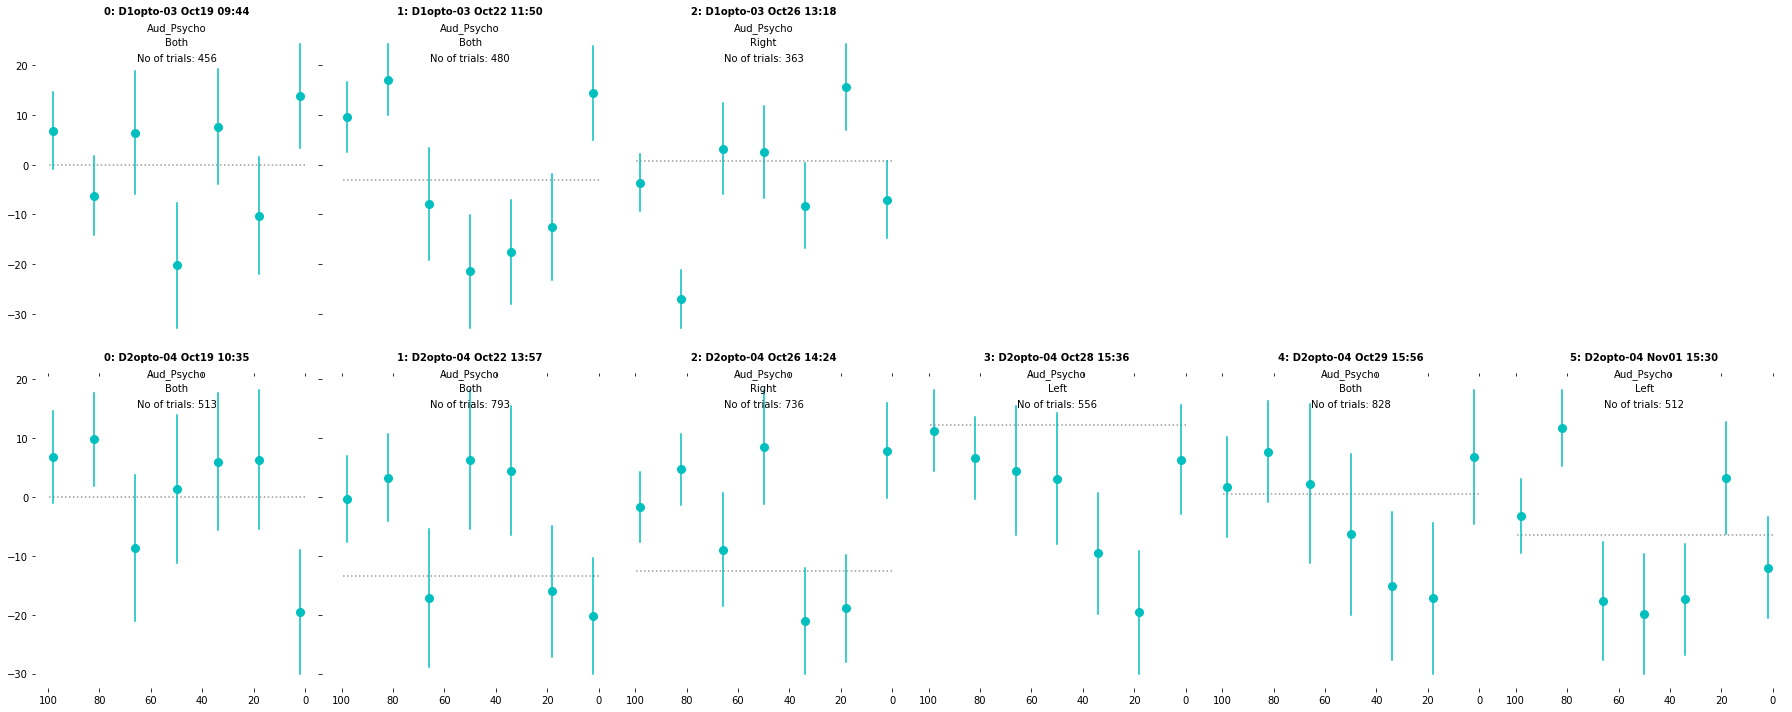

In [30]:
# Normalized:
n_cols = pulledData.groupby('AnimalID')['SessionID'].nunique().max()

fig, axs = plt.subplots(len(pd.unique(pulledData['AnimalID'])), n_cols,
                        figsize=(25, 5 * len(pd.unique(pulledData['AnimalID']))),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=1)

for ax in axs.ravel(): ax.axis('off')

for an_counter, animal in enumerate(pd.unique(pulledData['AnimalID'])):
    animal_df = pulledData[pulledData['AnimalID'] == animal]
    
    for counter, session in enumerate(pd.unique(animal_df['SessionID'])):
        ax = axs[an_counter, counter]
        
        ax.hlines(0, 0, 100, linestyles='dotted', alpha=0.4)
        
        plot_utils.plot_random_optolike_choices(df=animal_df[(animal_df['SessionID'] == session)],
                                                ax=ax,
                                                fake_dataset_m_and_std=fd_m_and_std,
                                                normalize=True)

        #axs[counter].set_ylabel('')
        #axs[counter].set_xlabel('')
        ax.axis('on')
        # remove some ticks
        ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                       labelleft='on', labelbottom='on')
        if not ax.is_first_col():
            ax.set_ylabel('')
            ax.set_yticks([])
        if not ax.is_last_row():
            ax.set_xlabel('')
            ax.set_xticks([])
                   
#         ax.set_ylim(-2., 102.)
        #ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
        ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
                       labelleft='on', labelbottom='on')
        # get rid of the frame
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        plt.tight_layout()
        
        ax.invert_xaxis()
        
#         ax.get_legend().remove()
        ax.text(.5,1.05, str(counter) + ': ' + (session), \
                          horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

        ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.95, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.9, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
                          horizontalalignment='center', transform=ax.transAxes)

    update_progress(an_counter / len(pd.unique(pulledData['AnimalID'])))
    
update_progress(1)
plt.savefig(outputDir + output_directory_name + '_difficulty_significance_for_individual_opto_sessions_normalized.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

Progress: [####################] 100.0%


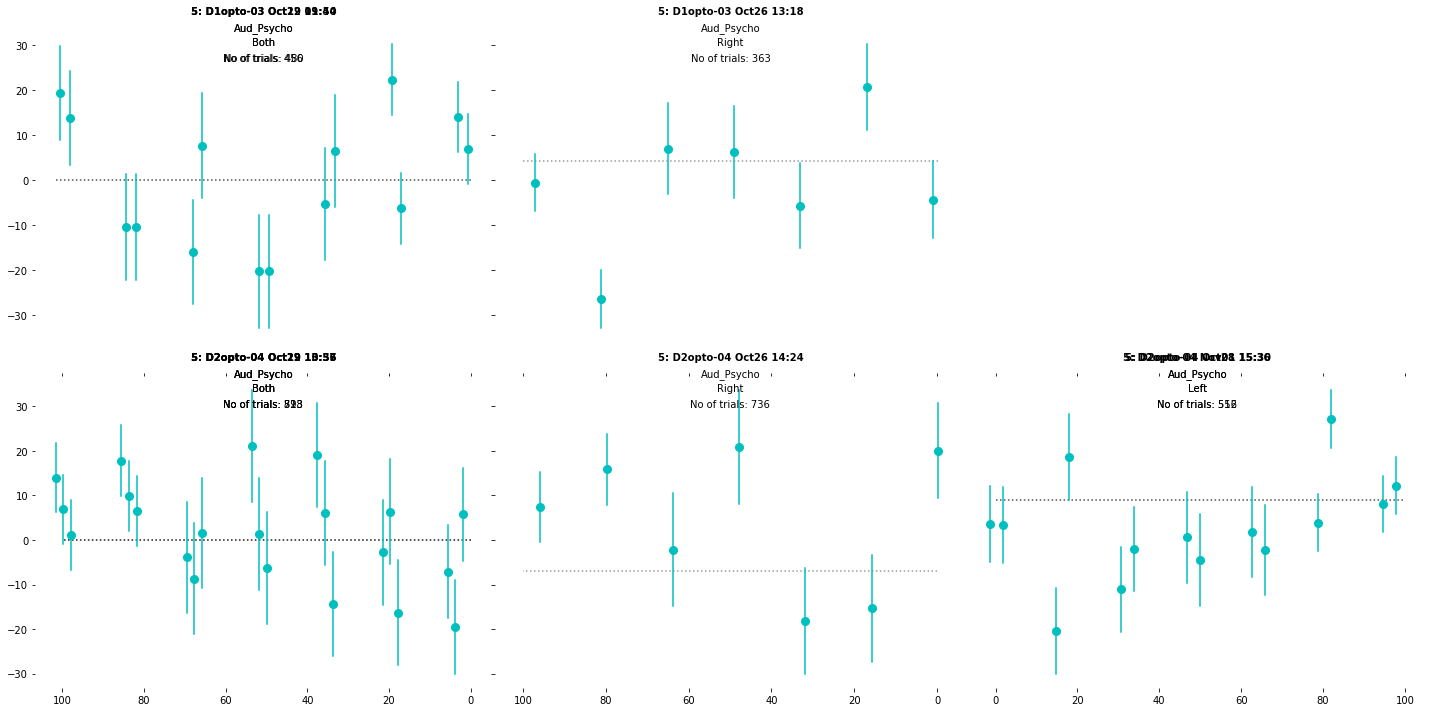

In [31]:
# Normalized and grouped:
n_cols = 3

fig, axs = plt.subplots(len(pd.unique(pulledData['AnimalID'])), n_cols,
                        figsize=(20, 5 * len(pd.unique(pulledData['AnimalID']))),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=1)

for ax in axs.ravel(): ax.axis('off')

for an_counter, animal in enumerate(pd.unique(pulledData['AnimalID'])):
    animal_df = pulledData[pulledData['AnimalID'] == animal]
    
    for session in pd.unique(animal_df['SessionID']):
        session_df = animal_df[animal_df['SessionID'] == session]
        opto_side = session_df.iloc[0]['Stimulation']
        if opto_side == 'Both':
            ax = axs[an_counter, 0]
        elif opto_side == 'Right':
            ax = axs[an_counter, 1]
        elif opto_side == 'Left':
            ax = axs[an_counter, 2]
        else:
            sys.exit('Issue with opto text')
        True
        ax.hlines(0, 0, 100, linestyles='dotted', alpha=0.4)
        
        plot_utils.plot_random_optolike_choices(df=session_df,
                                                ax=ax,
                                                fake_dataset_m_and_std=fd_m_and_std,
                                                normalize=True,
                                                jitter=4)

        #axs[counter].set_ylabel('')
        #axs[counter].set_xlabel('')
        ax.axis('on')
        # remove some ticks
        ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                       labelleft='on', labelbottom='on')
        if not ax.is_first_col():
            ax.set_ylabel('')
            ax.set_yticks([])
        if not ax.is_last_row():
            ax.set_xlabel('')
            ax.set_xticks([])
                   
#         ax.set_ylim(-2., 102.)
        #ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
        ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
                       labelleft='on', labelbottom='on')
        # get rid of the frame
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        plt.tight_layout()
        
        ax.invert_xaxis()
        
#         ax.get_legend().remove()
        ax.text(.5,1.05, str(counter) + ': ' + (session), \
                          horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

        ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.95, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.9, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
                          horizontalalignment='center', transform=ax.transAxes)

    update_progress(an_counter / len(pd.unique(pulledData['AnimalID'])))
    
update_progress(1)
plt.savefig(outputDir + output_directory_name + '_difficulty_significance_for_individual_opto_sessions_normalized_grouped.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [ ]:
# Fit and quantify

#### Deprecated

In [ ]:
# Plot with scikit-learn (does not work very well)

CondList = [(pulledData['OptoStim']==0),
            (pulledData['OptoStim']==1)]
ColorList = ['c', 'm']
LabelList = ['Normal', 'Opto']

n_cols = pulledData.groupby('AnimalID')['SessionID'].nunique().max()

fig, axs = plt.subplots(len(pd.unique(pulledData['AnimalID'])), n_cols,
                        figsize=(25, 5 * len(pd.unique(pulledData['AnimalID']))),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=.2)

for ax in axs.ravel(): ax.axis('off')

for an_counter, animal in enumerate(pd.unique(pulledData['AnimalID'])):
    animal_df = pulledData[pulledData['AnimalID'] == animal]
    
    for counter, session in enumerate(pd.unique(animal_df['SessionID'])):
        ax = axs[an_counter, counter]
        
        ax.hlines(50, 0, 100, linestyles='dotted', alpha=0.4)
        
        for i, condition in enumerate(CondList):
            predictDif, PsyPer, fakePredictions, predictPer, _ = \
            cuf.PP_ProcessExperiment(animal_df[(animal_df['SessionID'] == session) & condition], bootstrap=5)
            if PsyPer:
                plot_utils.PlotPsychPerformance(dataDif=PsyPer['Difficulty'], dataPerf=PsyPer['Performance'],
                                                predictDif=predictDif, ax=ax, fakePred=fakePredictions,
                                                realPred =predictPer, color=ColorList[i], label=LabelList[i])

        ax.get_legend().remove()
        ax.text(.5,.95, str(counter) + ': ' + (session), \
                          horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

        ax.text(.5,.85, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.75, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.65, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
                          horizontalalignment='center', transform=ax.transAxes)

        #axs[counter].set_ylabel('')
        #axs[counter].set_xlabel('')
        ax.axis('on')
        # remove some ticks
        ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                       labelleft='on', labelbottom='on')
        if not ax.is_first_col():
            ax.set_ylabel('')
            ax.set_yticks([])
        if not ax.is_last_row():
            ax.set_xlabel('')
            ax.set_xticks([])
        plt.tight_layout()

    update_progress(an_counter / len(pd.unique(pulledData['AnimalID'])))
    
update_progress(1)
plt.savefig(outputDir + output_directory_name + '_scikit-learn_fits_for_individual_opto_sessions.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

Progress: [####################] 100.0%


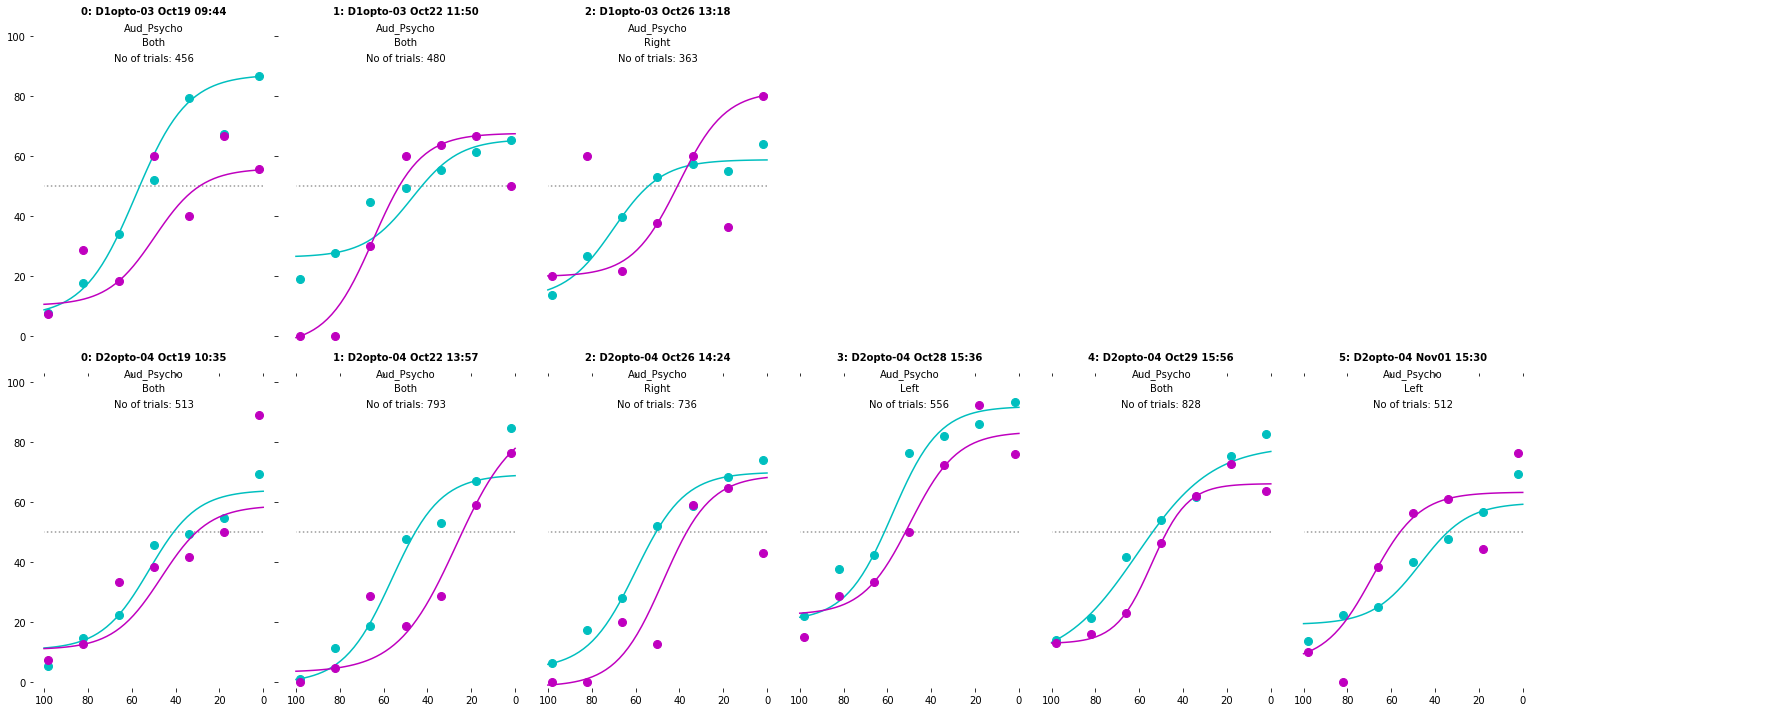

In [25]:
CondList = [(pulledData['OptoStim']==0),
            (pulledData['OptoStim']==1)]
ColorList = ['c', 'm']
LabelList = ['Normal', 'Opto']

n_cols = pulledData.groupby('AnimalID')['SessionID'].nunique().max() + 1

fig, axs = plt.subplots(len(pd.unique(pulledData['AnimalID'])), n_cols,
                        figsize=(25, 5 * len(pd.unique(pulledData['AnimalID']))),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=1)

for ax in axs.ravel(): ax.axis('off')

for an_counter, animal in enumerate(pd.unique(pulledData['AnimalID'])):
    animal_df = pulledData[pulledData['AnimalID'] == animal]
    
    for counter, session in enumerate(pd.unique(animal_df['SessionID'])):
        ax = axs[an_counter, counter]
        
        ax.hlines(50, 0, 100, linestyles='dotted', alpha=0.4)
        
        for i, condition in enumerate(CondList):
            
            plot_utils.plot_regression(df=animal_df[(animal_df['SessionID'] == session) & condition], ax=ax,
                                       color = ColorList[i], label = LabelList[i])

        #axs[counter].set_ylabel('')
        #axs[counter].set_xlabel('')
        ax.axis('on')
        # remove some ticks
        ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                       labelleft='on', labelbottom='on')
        if not ax.is_first_col():
            ax.set_ylabel('')
            ax.set_yticks([])
        if not ax.is_last_row():
            ax.set_xlabel('')
            ax.set_xticks([])
                   
        ax.set_ylim(-2., 102.)
        #ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
        ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
                       labelleft='on', labelbottom='on')
        # get rid of the frame
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        plt.tight_layout()
        
        ax.invert_xaxis()
        
        ax.get_legend().remove()
        ax.text(.5,1.05, str(counter) + ': ' + (session), \
                          horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

        ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.95, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.9, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
                          horizontalalignment='center', transform=ax.transAxes)

    update_progress(an_counter / len(pd.unique(pulledData['AnimalID'])))
    
update_progress(1)
plt.savefig(outputDir + output_directory_name + '_custom_fits_for_individual_opto_sessions.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

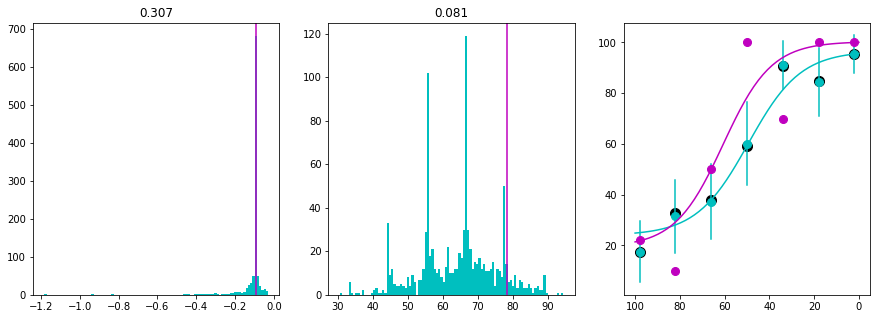

In [22]:
session = 'D1opto-01 Jul29 09:29'
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax=ax.ravel()
session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
opto_df = pulledData[(pulledData['SessionID'] == session) & (pulledData['OptoStim']==1)]
trialsDif = np.array(opto_df['TrialHighPerc'])
sideSelected = np.array(opto_df['FirstPoke'])
difficulty, performance = cuf.get_choices(sideSelected, trialsDif)

s, b, u, l = cuf.fit_custom_sigmoid(difficulty=difficulty, performance=performance)
ups = cuf.sigmoid_func(50, s, b, u, l)

plot_hist_and_line(random_opto_df.loc[session_idx].sf_slopes, s, ax=ax[0])
ax[0].set_title(np.sum(random_opto_df.loc[session_idx].sf_slopes > s) / len(random_opto_df.loc[session_idx].sf_slopes))
plot_hist_and_line(random_opto_df.loc[session_idx].sf_updown_shift, ups, ax=ax[1])
ax[1].set_title(np.sum(random_opto_df.loc[session_idx].sf_updown_shift > ups) / len(random_opto_df.loc[session_idx].sf_intercepts))


session_df = pulledData[pulledData['SessionID'] == session]
avail_diffs = random_opto_df[random_opto_df.SessionID == session].Difficulties.item()
rand_choices_ds = random_opto_df[random_opto_df.SessionID == session].Random_choices.item()

plot_utils.plot_random_optolike_choices(df=session_df,
                                        ax=ax[2],
                                        fake_dataset_m_and_std=[avail_diffs,
                                                                np.mean(rand_choices_ds, axis=0),
                                                                np.std(rand_choices_ds, axis=0)])
# overlay fits
CondList = [(pulledData['OptoStim']==0),
            (pulledData['OptoStim']==1)]
ColorList = ['c', 'm']
LabelList = ['Normal', 'Opto']
for i, condition in enumerate(CondList):
    plot_utils.plot_regression(df=pulledData[(pulledData['SessionID'] == session) & condition], ax=ax[2],
                               color=ColorList[i], label=LabelList[i], plot_points=False)

ax[2].invert_xaxis()

In [21]:
# This is weird, see session 'D2opto-03 Oct29 15:56'
# plot one of the session with higher intercept
r_s = random.choice(np.where(random_opto_df.loc[session_idx].sf_updown_shift > ups)[0])
s_r, b_r, u_r, l_r = cuf.fit_custom_sigmoid(difficulty=difficulty, performance=rand_choices_ds[r_s])
x = np.linspace(0, 100)

ups_r = cuf.sigmoid_func(50,s_r, b_r, u_r, l_r)

fig, ax = plt.subplots(1,1)
ax.plot(difficulty, performance, 'o', color='m')
ax.plot(difficulty, rand_choices_ds[r_s], 'o', color='c')
sns.lineplot(x=x,
             y=cuf.sigmoid_func(x, *[s, b, u, l]),
             color='m',
             ci=None,
             ax=ax)
sns.lineplot(x=x,
             y=cuf.sigmoid_func(x, *[s_r, b_r, u_r, l_r]),
             color='c',
             ci=None,
             ax=ax)
ax.invert_xaxis()
ax.set_title('opto: {}; random: {}'.format(ups, ups_r))
plt.show()

IndexError: Cannot choose from an empty sequence